In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
batch_size = 4
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


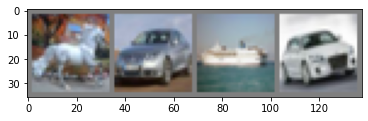

horse   car  ship   car


In [3]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [5]:
class NetMod(nn.Module):
    def __init__(self):
        super(NetMod, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=10)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(F.relu(x))
        x = self.dropout(x)
        x = self.fc3(F.relu(x))
        x = F.relu(x)
        return x

net = NetMod()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

NetMod(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [6]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

In [7]:
avg_losses = []   # Avg. losses.
epochs = 90       # Total epochs.
print_freq = 2000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.5f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:  1999] avg mini-batch loss: 2.30277
[epoch: 0, i:  3999] avg mini-batch loss: 2.30276
[epoch: 0, i:  5999] avg mini-batch loss: 2.30224
[epoch: 0, i:  7999] avg mini-batch loss: 2.30236
[epoch: 0, i:  9999] avg mini-batch loss: 2.29355
[epoch: 0, i: 11999] avg mini-batch loss: 2.19768
[epoch: 1, i:  1999] avg mini-batch loss: 2.00853
[epoch: 1, i:  3999] avg mini-batch loss: 1.91584
[epoch: 1, i:  5999] avg mini-batch loss: 1.84490
[epoch: 1, i:  7999] avg mini-batch loss: 1.76457
[epoch: 1, i:  9999] avg mini-batch loss: 1.69067
[epoch: 1, i: 11999] avg mini-batch loss: 1.62422
[epoch: 2, i:  1999] avg mini-batch loss: 1.54331
[epoch: 2, i:  3999] avg mini-batch loss: 1.44477
[epoch: 2, i:  5999] avg mini-batch loss: 1.39195
[epoch: 2, i:  7999] avg mini-batch loss: 1.33540
[epoch: 2, i:  9999] avg mini-batch loss: 1.28774
[epoch: 2, i: 11999] avg mini-batch loss: 1.23335
[epoch: 3, i:  1999] avg mini-batch loss: 1.14892
[epoch: 3, i:  3999] avg mini-batch loss: 1.08411


[epoch: 27, i:  1999] avg mini-batch loss: 0.05838
[epoch: 27, i:  3999] avg mini-batch loss: 0.09506
[epoch: 27, i:  5999] avg mini-batch loss: 0.11195
[epoch: 27, i:  7999] avg mini-batch loss: 0.09296
[epoch: 27, i:  9999] avg mini-batch loss: 0.11649
[epoch: 27, i: 11999] avg mini-batch loss: 0.12468
[epoch: 28, i:  1999] avg mini-batch loss: 0.06577
[epoch: 28, i:  3999] avg mini-batch loss: 0.07578
[epoch: 28, i:  5999] avg mini-batch loss: 0.08958
[epoch: 28, i:  7999] avg mini-batch loss: 0.11909
[epoch: 28, i:  9999] avg mini-batch loss: 0.09140
[epoch: 28, i: 11999] avg mini-batch loss: 0.10297
[epoch: 29, i:  1999] avg mini-batch loss: 0.08139
[epoch: 29, i:  3999] avg mini-batch loss: 0.09819
[epoch: 29, i:  5999] avg mini-batch loss: 0.07996
[epoch: 29, i:  7999] avg mini-batch loss: 0.09247
[epoch: 29, i:  9999] avg mini-batch loss: 0.08110
[epoch: 29, i: 11999] avg mini-batch loss: 0.11055
[epoch: 30, i:  1999] avg mini-batch loss: 0.07058
[epoch: 30, i:  3999] avg mini-

[epoch: 53, i: 11999] avg mini-batch loss: 0.10020
[epoch: 54, i:  1999] avg mini-batch loss: 0.05215
[epoch: 54, i:  3999] avg mini-batch loss: 0.06199
[epoch: 54, i:  5999] avg mini-batch loss: 0.08027
[epoch: 54, i:  7999] avg mini-batch loss: 0.09524
[epoch: 54, i:  9999] avg mini-batch loss: 0.07959
[epoch: 54, i: 11999] avg mini-batch loss: 0.09693
[epoch: 55, i:  1999] avg mini-batch loss: 0.05426
[epoch: 55, i:  3999] avg mini-batch loss: 0.07992
[epoch: 55, i:  5999] avg mini-batch loss: 0.05701
[epoch: 55, i:  7999] avg mini-batch loss: 0.08990
[epoch: 55, i:  9999] avg mini-batch loss: 0.10068
[epoch: 55, i: 11999] avg mini-batch loss: 0.09552
[epoch: 56, i:  1999] avg mini-batch loss: 0.05897
[epoch: 56, i:  3999] avg mini-batch loss: 0.07142
[epoch: 56, i:  5999] avg mini-batch loss: 0.08440
[epoch: 56, i:  7999] avg mini-batch loss: 0.09000
[epoch: 56, i:  9999] avg mini-batch loss: 0.08685
[epoch: 56, i: 11999] avg mini-batch loss: 0.09989
[epoch: 57, i:  1999] avg mini-

[epoch: 80, i:  9999] avg mini-batch loss: 0.09136
[epoch: 80, i: 11999] avg mini-batch loss: 0.09979
[epoch: 81, i:  1999] avg mini-batch loss: 0.05696
[epoch: 81, i:  3999] avg mini-batch loss: 0.04673
[epoch: 81, i:  5999] avg mini-batch loss: 0.07635
[epoch: 81, i:  7999] avg mini-batch loss: 0.07035
[epoch: 81, i:  9999] avg mini-batch loss: 0.08410
[epoch: 81, i: 11999] avg mini-batch loss: 0.09449
[epoch: 82, i:  1999] avg mini-batch loss: 0.05795
[epoch: 82, i:  3999] avg mini-batch loss: 0.08185
[epoch: 82, i:  5999] avg mini-batch loss: 0.08019
[epoch: 82, i:  7999] avg mini-batch loss: 0.07746
[epoch: 82, i:  9999] avg mini-batch loss: 0.07409
[epoch: 82, i: 11999] avg mini-batch loss: 0.07754
[epoch: 83, i:  1999] avg mini-batch loss: 0.06575
[epoch: 83, i:  3999] avg mini-batch loss: 0.06954
[epoch: 83, i:  5999] avg mini-batch loss: 0.08591
[epoch: 83, i:  7999] avg mini-batch loss: 0.07987
[epoch: 83, i:  9999] avg mini-batch loss: 0.09317
[epoch: 83, i: 11999] avg mini-

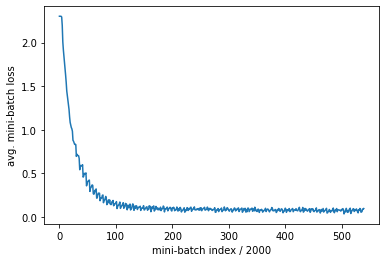

In [8]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

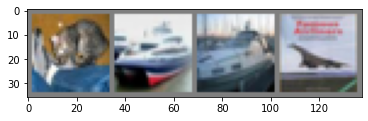

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [9]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

In [10]:
# Get test accuracy.
correct = 0
total = 0

net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

net.train()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 79 %


In [11]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 79 %
Accuracy of   car : 88 %
Accuracy of  bird : 74 %
Accuracy of   cat : 68 %
Accuracy of  deer : 74 %
Accuracy of   dog : 65 %
Accuracy of  frog : 82 %
Accuracy of horse : 83 %
Accuracy of  ship : 90 %
Accuracy of truck : 89 %
